In [1]:
import math
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
from matplotlib import figure


In [2]:
# raw_df = pd.read_csv('27612.02.05.2023.02.05.2024.1.0.0.ru.utf8.00000000.csv', delimiter=';', index_col=False)
raw_df = pd.read_csv('27612.02.05.2005.02.05.2024.1.0.0.ru.utf8.00000000.csv', delimiter=';', index_col=False)

In [3]:
def plot_df(df: pd.DataFrame, y_column, xtick_step, title='заголовок', value='показатель'):

    plt.figure(figsize=(24, 12), dpi=80)

    fig, ax1 = plt.subplots(1, figsize=(24,12))
    
    ax1.plot(df.index, df[y_column])
    ax1.set_xticks(df.index[::xtick_step])
    ax1.set_xticklabels(df.index[::xtick_step], rotation=90)

    plt.title(f"{title}")
    plt.xlabel('День')
    plt.ylabel(value)
    plt.grid(True)
    plt.legend()
    plt.show()

    # plt.savefig(name_output)
    # plt.close(fig)

In [4]:
raw_df = raw_df.drop([i for i in raw_df.columns if i not in ['Местное время в Москве (ВДНХ)', 'T', 'Po', 'U', 'RRR']], axis=1)

In [5]:
df = pd.DataFrame()

df['Time'] = raw_df['Местное время в Москве (ВДНХ)']
df['T'] = raw_df['T']

df[['day','month', 'year']] = df['Time'].str.split('.',expand=True)
df[['year', 'hour']] = df['year'].str.split(' ',expand=True)
df['Time'] = df['Time'].str.replace(' ', '_')

df = df.set_index('Time', drop=True)


In [6]:
df.loc[df['T'] > 30]

,T,day,month,year,hour
Time,,,,,
06.08.2023_18:00,30.2,06,08,2023,18:00
06.08.2023_15:00,31.1,06,08,2023,15:00
06.08.2023_12:00,30.5,06,08,2023,12:00
27.08.2022_15:00,30.8,27,08,2022,15:00
26.08.2022_15:00,30.2,26,08,2022,15:00
...,...,...,...,...,...
27.05.2007_15:00,30.6,27,05,2007,15:00
14.07.2006_15:00,30.6,14,07,2006,15:00
13.07.2006_12:00,30.2,13,07,2006,12:00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64845 entries, 02.05.2024_12:00 to 02.05.2005_00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       64838 non-null  float64
 1   day     64845 non-null  object 
 2   month   64845 non-null  object 
 3   year    64845 non-null  object 
 4   hour    64845 non-null  object 
dtypes: float64(1), object(4)
memory usage: 5.0+ MB


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1920x960 with 0 Axes>

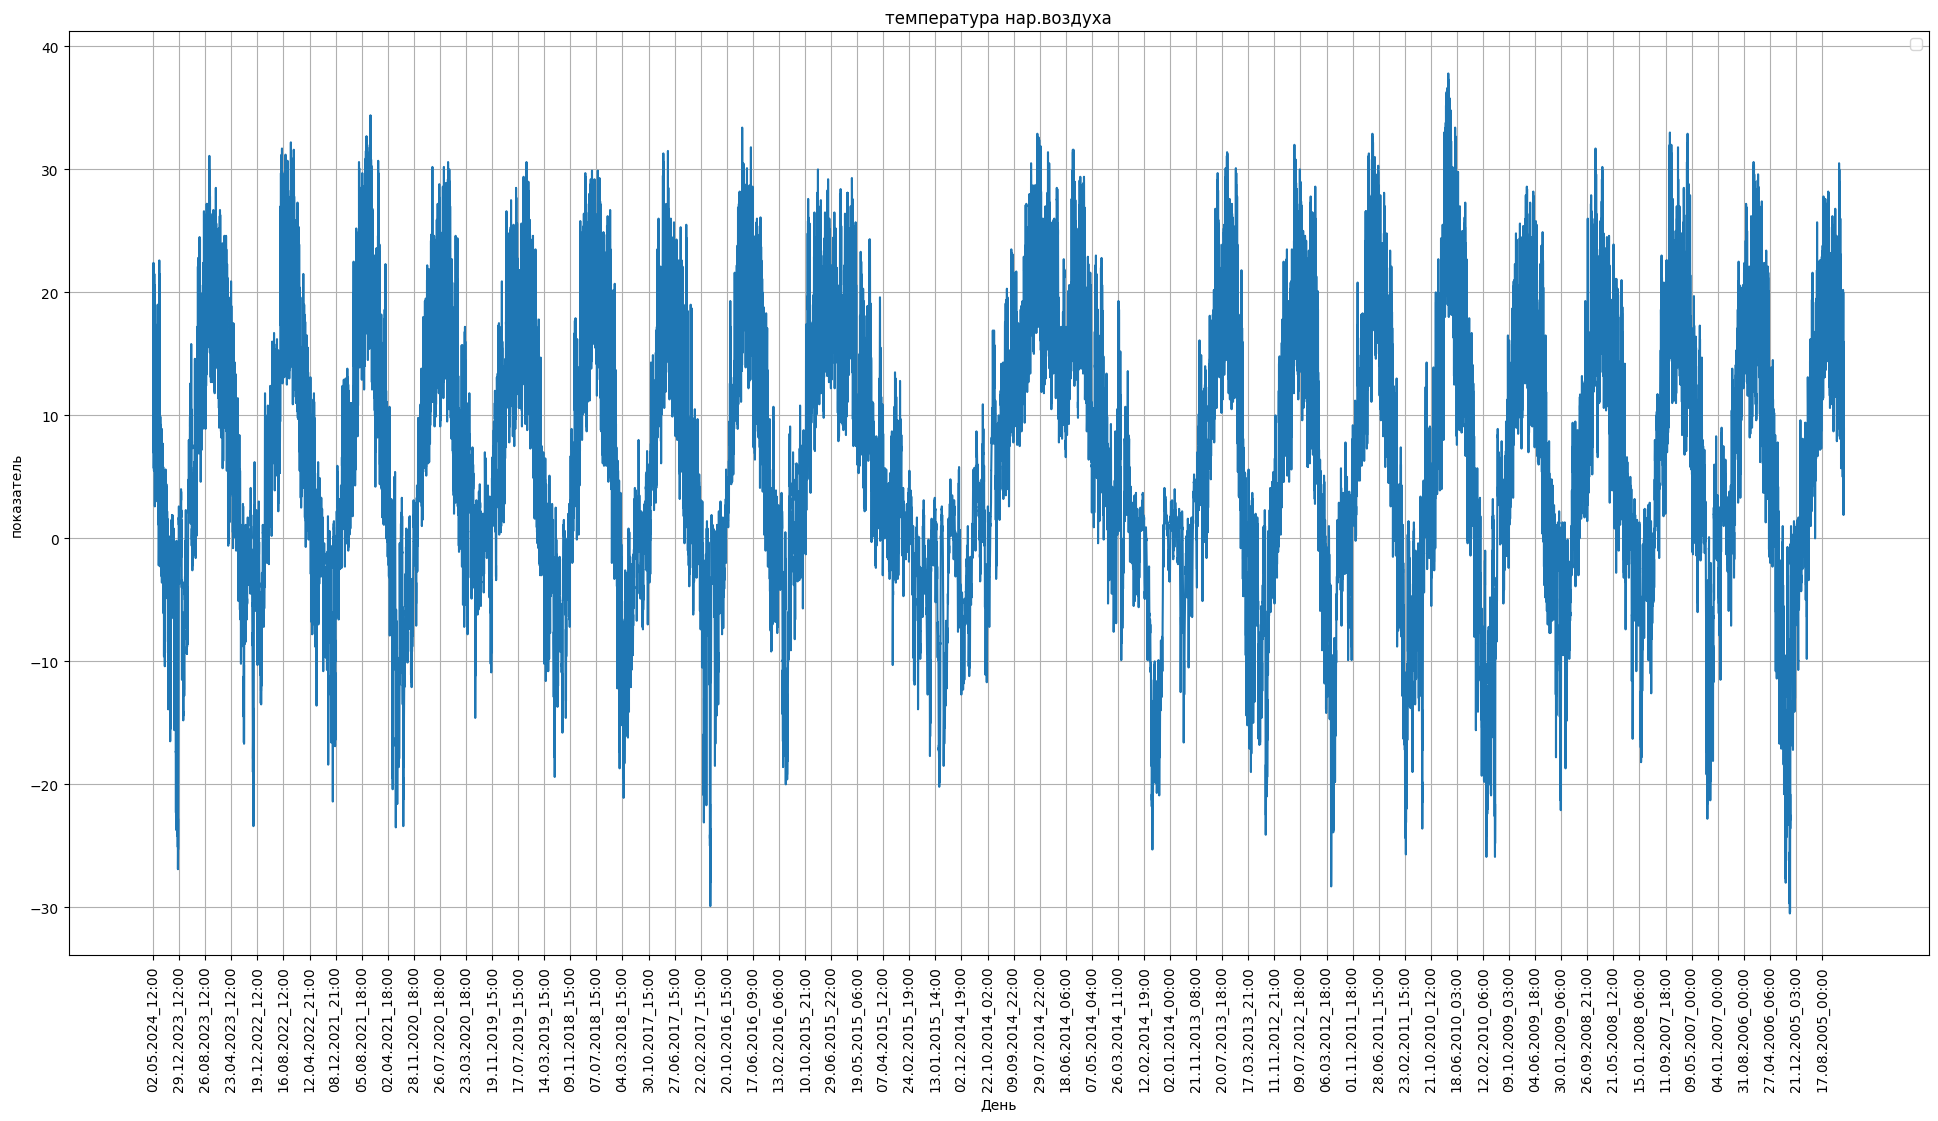

In [8]:
plot_df(df, 'T', 1000, 'температура нар.воздуха')

In [9]:
def Q_air_heating(G, t1, t2):
  # G м3/ч 
  # Q_air_heating кВт
  return round(0.278 * 1.21 * 1.005 * G * (t1-t2) / 1000, 0)


def G_air_heating(Q, t1, t2):
  # G м3/ч 
  # Q_air_heating кВт
  return int ((Q * 1000) / (0.278 * 1.21 * 1.005 * (t1-t2)) if t1 != t2 else 0)


In [10]:
#считаем что модуль мощностью 1.65 МВт 
Q_it = 1650

#считаем что расход воздуха через стойки постоянный 
# с разницей температур 7гр
t_hot_corridor_max = 35
t_cold_corridor_max = 28
delta_t = t_hot_corridor_max - t_cold_corridor_max
hours_step = 3

G_it = G_air_heating(Q_it, t_hot_corridor_max, t_cold_corridor_max)

fun_G_m3_h_intake = 19000
fun_number_intake = G_it // fun_G_m3_h_intake
fun_kW_e_intake = 6 

fun_G_m3_h_exhaust = 19000
fun_number_exhaust = G_it // fun_G_m3_h_exhaust
fun_kW_e_exhaust = 6 



cooling_temp_needs = []

df['G_intake'] = df['T'].map(lambda x: abs(G_air_heating(Q_it, t_hot_corridor_max, x)) if abs(x - t_hot_corridor_max) > delta_t else G_it)


df['G_recircle'] = G_it - df['G_intake']
df['G_full'] = G_it
df['G_%'] = 100* df['G_recircle'] / df['G_full'] 


for index, row in df.iterrows():
    cooling_temp_needs.append(round(t_hot_corridor_max - row['T'] - delta_t, 2)) if row['G_recircle'] == 0 else cooling_temp_needs.append(0)

df['cooling_needs_temp'] = cooling_temp_needs
df['cooling_kW*h'] = df['cooling_needs_temp'].map(lambda x: abs(hours_step * 0.278 * 1.21 * 1.005 * G_it * (x) / 1000))

df['IT_consume_kW*h'] = hours_step * Q_it

df['fan_in_kW*h'] = hours_step * fun_number_intake * fun_kW_e_intake # поддерживаем расход равный расходу вентиляторов в стойках 
df['fan_out_kW*h'] = df['G_intake'].map(lambda x: (math.ceil(x / fun_G_m3_h_exhaust) * fun_kW_e_exhaust * hours_step))  # расход выбрасываемого воздуха равен приточному уличному

df['PUE_cooling'] = (df['fan_out_kW*h'] + df['fan_in_kW*h'] + df['cooling_kW*h'] + df['IT_consume_kW*h']) / df['IT_consume_kW*h']


In [11]:
df.loc[df['PUE_cooling'] > 1.2]

,T,day,month,year,hour,G_intake,G_recircle,G_full,G_%,cooling_needs_temp,cooling_kW*h,IT_consume_kW*h,fan_in_kW*h,fan_out_kW*h,PUE_cooling
Time,,,,,,,,,,,,,,,
30.04.2024_18:00,21.8,30,04,2024,18:00,369754,327497,697251,46.969743,0.0,0.0,4950,648,360,1.203636
30.04.2024_15:00,22.4,30,04,2024,15:00,387362,309889,697251,44.444397,0.0,0.0,4950,648,378,1.207273
26.04.2024_12:00,21.5,26,04,2024,12:00,361537,335714,697251,48.148228,0.0,0.0,4950,648,360,1.203636
02.04.2024_18:00,22.4,02,04,2024,18:00,387362,309889,697251,44.444397,0.0,0.0,4950,648,378,1.207273
02.04.2024_15:00,22.6,02,04,2024,15:00,393609,303642,697251,43.548450,0.0,0.0,4950,648,378,1.207273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18.05.2005_18:00,22.9,18,05,2005,18:00,403368,293883,697251,42.148810,0.0,0.0,4950,648,396,1.210909
18.05.2005_15:00,23.1,18,05,2005,15:00,410148,287103,697251,41.176420,0.0,0.0,4950,648,396,1.210909
18.05.2005_12:00,23.0,18,05,2005,12:00,406730,290521,697251,41.666631,0.0,0.0,4950,648,396,1.210909


In [12]:
df.describe()

,T,G_intake,G_recircle,G_full,G_%,cooling_needs_temp,cooling_kW*h,IT_consume_kW*h,fan_in_kW*h,fan_out_kW*h,PUE_cooling
count,64838.000000,64845.000000,64845.000000,64845.0,64845.000000,64838.000000,64838.000000,64845.0,64845.0,64845.000000,64838.000000
mean,6.760713,209452.331236,487798.668764,697251.0,69.960268,-0.025248,17.853596,4950.0,648.0,207.344622,1.176394
std,10.767111,113075.727630,113075.727630,0.0,16.217363,0.297440,210.332397,0.0,0.0,107.108299,0.054234
min,-30.500000,74515.000000,0.000000,697251.0,0.000000,-9.800000,0.000000,4950.0,648.0,72.000000,1.145455
25%,-0.700000,136716.000000,450748.000000,697251.0,64.646447,0.000000,0.000000,4950.0,648.0,144.000000,1.160000
50%,6.200000,169470.000000,527781.000000,697251.0,75.694549,0.000000,0.000000,4950.0,648.0,162.000000,1.163636
75%,15.200000,246503.000000,560535.000000,697251.0,80.392140,0.000000,0.000000,4950.0,648.0,234.000000,1.178182
max,37.800000,697251.000000,622736.000000,697251.0,89.313031,0.000000,6929.991536,4950.0,648.0,666.000000,2.665453


In [13]:
df.dropna(inplace=True)

In [14]:
sum(df['cooling_kW*h'])

1157591.443377016

In [15]:
df.loc[df['PUE_cooling'] > 1.2].count()

T                     5663
day                   5663
month                 5663
year                  5663
hour                  5663
G_intake              5663
G_recircle            5663
G_full                5663
G_%                   5663
cooling_needs_temp    5663
cooling_kW*h          5663
IT_consume_kW*h       5663
fan_in_kW*h           5663
fan_out_kW*h          5663
PUE_cooling           5663
dtype: int64

In [16]:
sum(df['cooling_kW*h']) 

1157591.443377016

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1920x960 with 0 Axes>

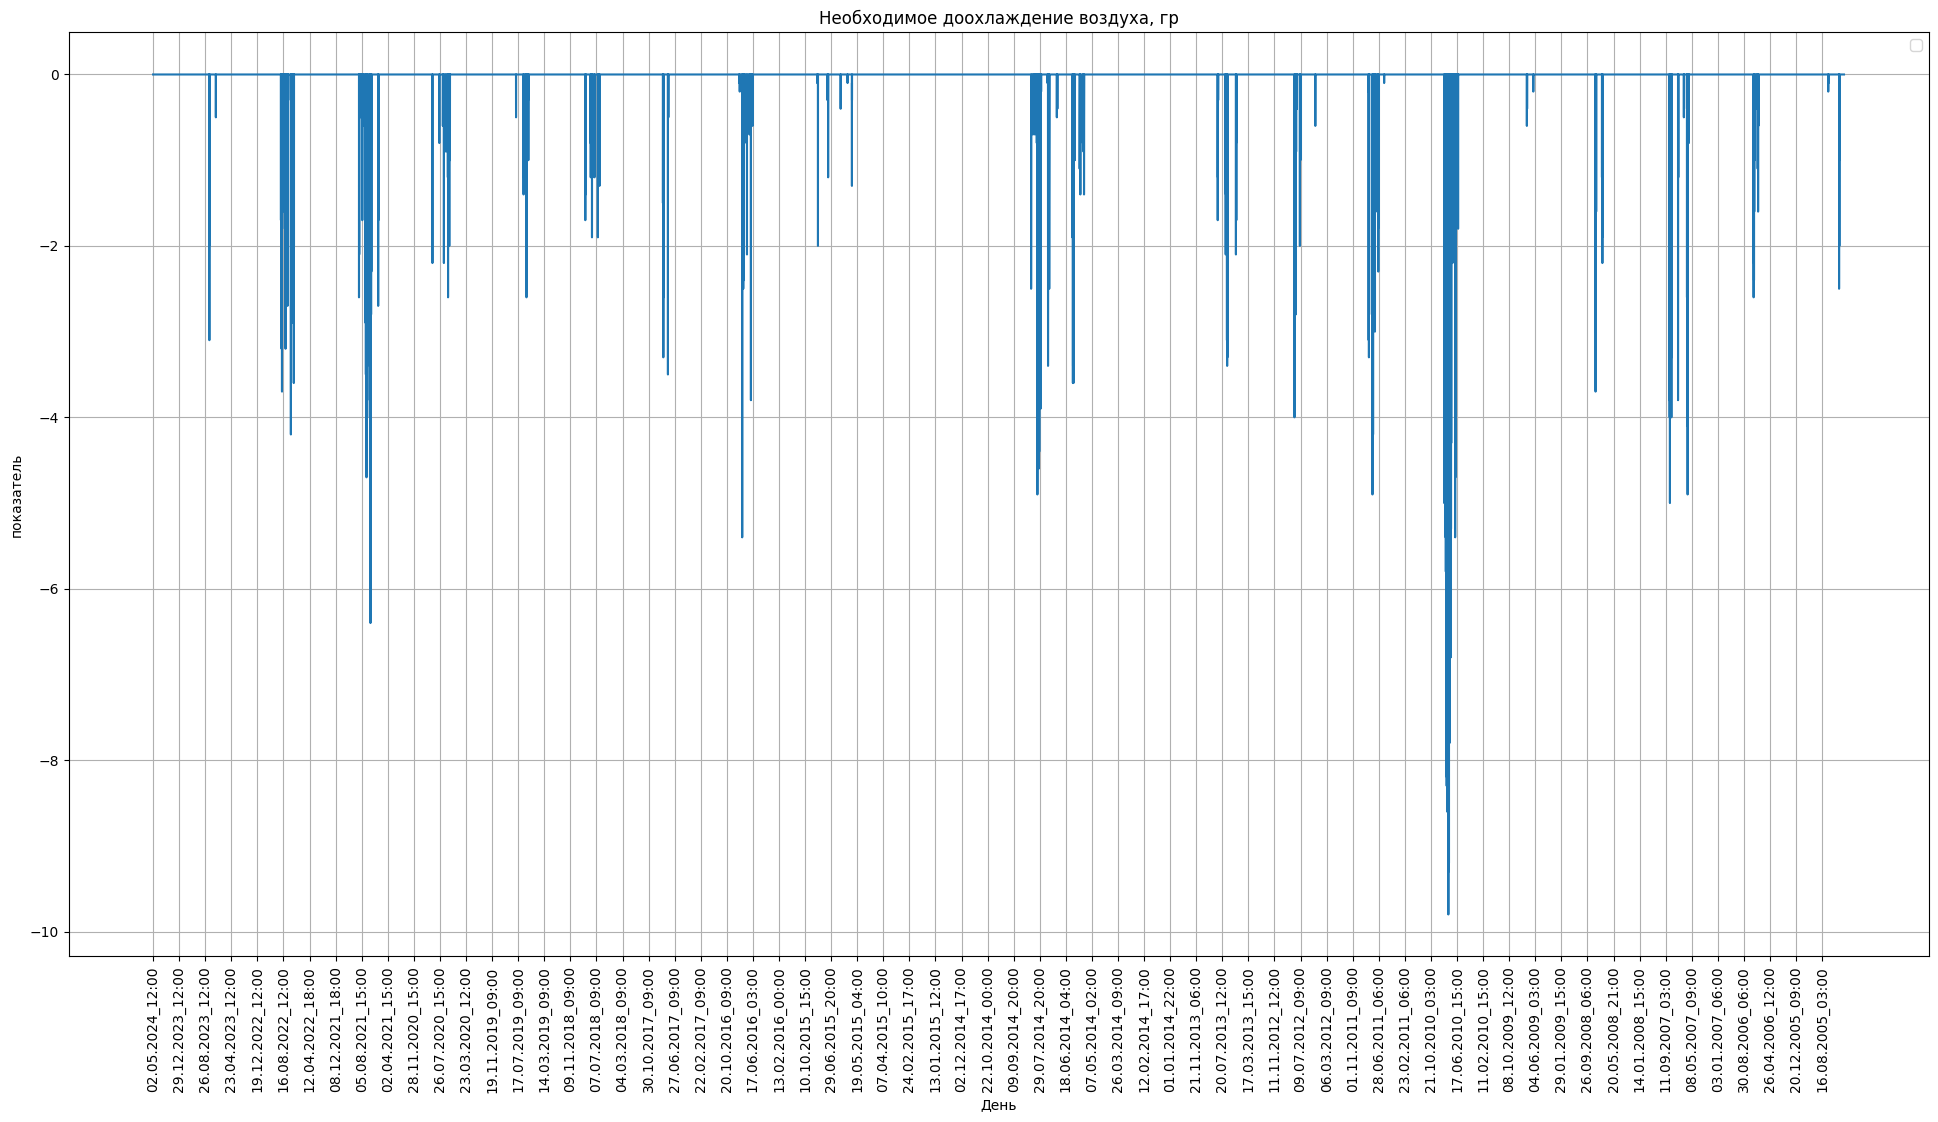

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1920x960 with 0 Axes>

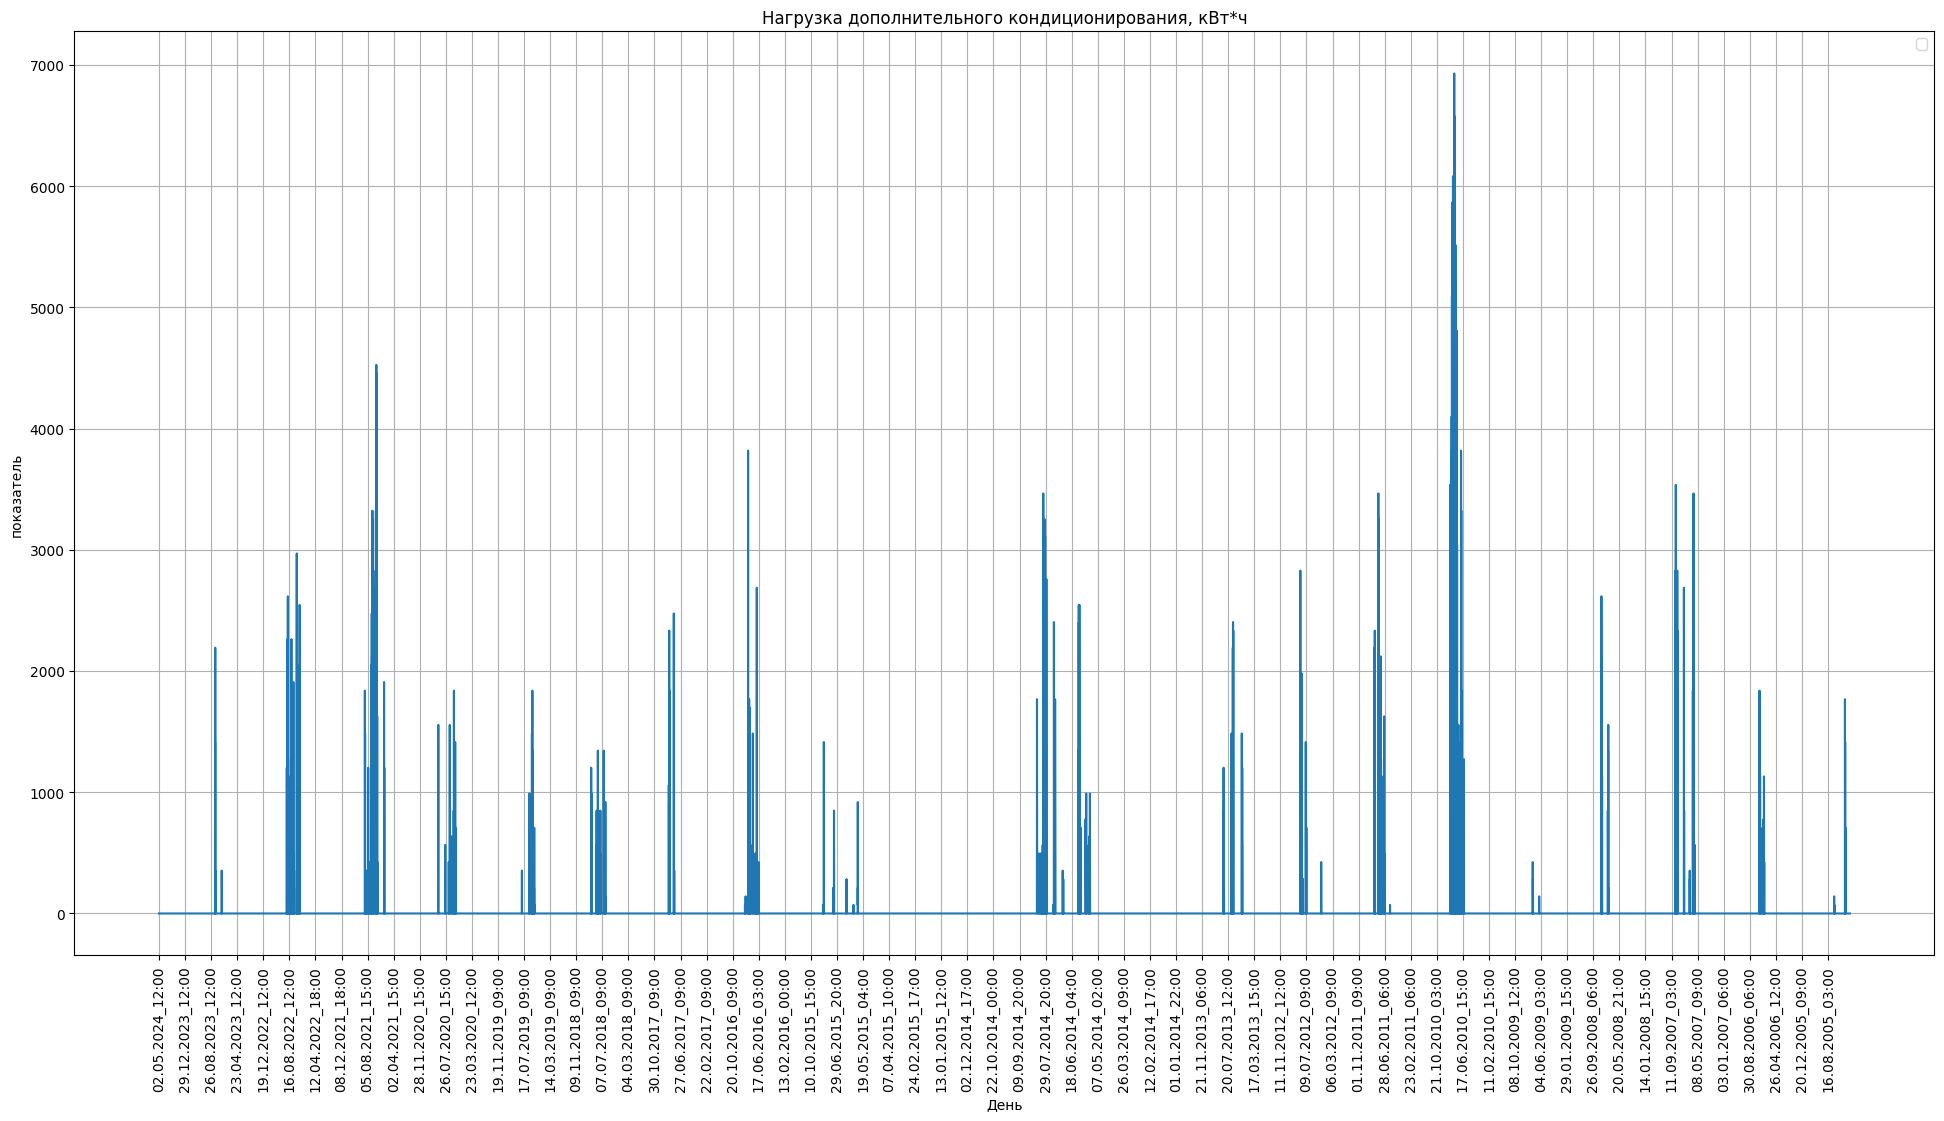

In [17]:
plot_df(df, 'cooling_needs_temp', 1000, 'Необходимое доохлаждение воздуха, гр')
plot_df(df, 'cooling_kW*h', 1000,  'Нагрузка дополнительного кондиционирования, кВт*ч')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1920x960 with 0 Axes>

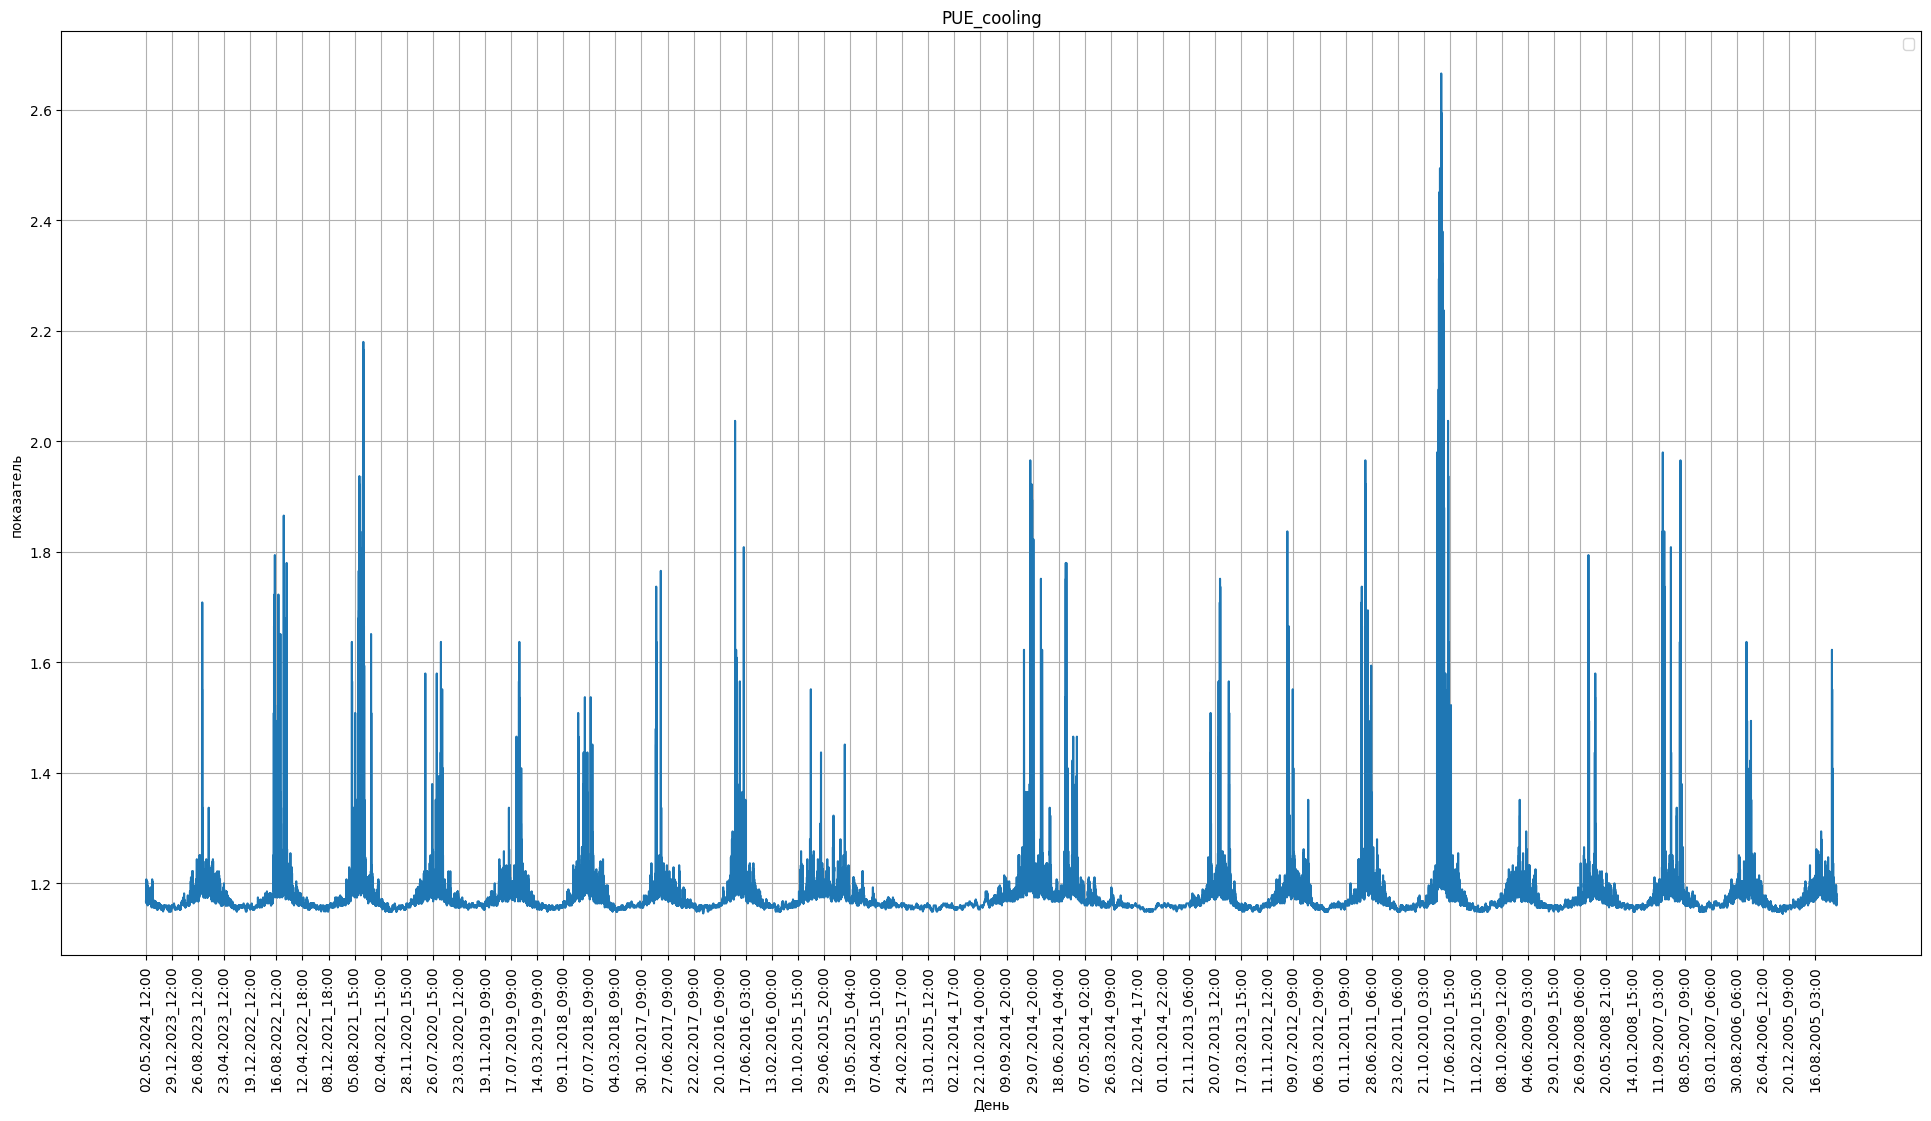

In [18]:
plot_df(df,'PUE_cooling', 1000, 'PUE_cooling')

In [19]:
df.describe()

,T,G_intake,G_recircle,G_full,G_%,cooling_needs_temp,cooling_kW*h,IT_consume_kW*h,fan_in_kW*h,fan_out_kW*h,PUE_cooling
count,64838.000000,64838.000000,64838.000000,64838.0,64838.000000,64838.000000,64838.000000,64838.0,64838.0,64838.000000,64838.000000
mean,6.760713,209399.667818,487851.332182,697251.0,69.967821,-0.025248,17.853596,4950.0,648.0,207.295105,1.176394
std,10.767111,112968.173804,112968.173804,0.0,16.201938,0.297440,210.332397,0.0,0.0,107.008000,0.054234
min,-30.500000,74515.000000,0.000000,697251.0,0.000000,-9.800000,0.000000,4950.0,648.0,72.000000,1.145455
25%,-0.700000,136716.000000,450748.000000,697251.0,64.646447,0.000000,0.000000,4950.0,648.0,144.000000,1.160000
50%,6.200000,169470.000000,527781.000000,697251.0,75.694549,0.000000,0.000000,4950.0,648.0,162.000000,1.163636
75%,15.200000,246503.000000,560535.000000,697251.0,80.392140,0.000000,0.000000,4950.0,648.0,234.000000,1.178182
max,37.800000,697251.000000,622736.000000,697251.0,89.313031,0.000000,6929.991536,4950.0,648.0,666.000000,2.665453


In [20]:
print(f"min PUE_cooling - {df['PUE_cooling'].min()}" )
print(f"mean PUE_cooling - {df['PUE_cooling'].mean()}" )
print(f"max PUE_cooling - {df['PUE_cooling'].max()}" )
print(f"variance PUE_cooling - {df['PUE_cooling'].var()}" )
print(f"std PUE_cooling - {df['PUE_cooling'].std()}" )

min PUE_cooling - 1.1454545454545455
mean PUE_cooling - 1.1763936768698022
max PUE_cooling - 2.6654528356373457
variance PUE_cooling - 0.00294132213167316
std PUE_cooling - 0.054233957366885556


In [21]:
print(f" PUE < 1.2 --- {len(df.loc[df['PUE_cooling'] < 1.2]) / len(df.loc[df['PUE_cooling'] > 1.0]) * 100} %")
print(f" PUE < 1.4 --- {len(df.loc[df['PUE_cooling'] < 1.4]) / len(df.loc[df['PUE_cooling'] > 1.0]) * 100} %")

 PUE < 1.2 --- 89.81153027545575 %
 PUE < 1.4 --- 99.19337425583763 %


In [22]:
print(f"Мощность системы охлаждения одного блока по quantile(0.95) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.95) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по quantile(0.99) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.99) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по max значению - {int(df['cooling_kW*h'].max() / hours_step)} кВт" )

Мощность системы охлаждения одного блока по quantile(0.95) значению - 1268 кВт
Мощность системы охлаждения одного блока по quantile(0.99) значению - 1838 кВт
Мощность системы охлаждения одного блока по max значению - 2309 кВт
